# Cluster count-only SACC file creation

This notebook examplifies the creation of a SACC file for cluster count, using pre-extracted halo catalog from the SkySim dataset. It
- shows how to load the data
- counts halos in the richness and redshift plane
- computes the covariance using jackknife resampling (to be eventually done by TJPCov)
- **save the count and covariance in the SACC format**

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyccl as ccl
import sacc

In [2]:
sacc.__version__

'0.4.9'

## Load halo list
This is reading a file prepared from the SkySim dataset and stored at CC-in2p3 or NERSC (uncomment as needed)

In [3]:
path_to_cat = '/sps/lsst/users/ccombet/SkySim5000/hdf5' # CC-in2p3
# path_to_cat = '/global/u1/c/ccombet/SkySim5000/hdf5' # NERSC

size = 'image' # other options are 'image' (440 deg2) and 'small' (57 deg2), 'full' (5000 deg2)

with pd.HDFStore(os.path.join(path_to_cat,f'skysim_halos_z=0-1.20_mfof_gt_1.00e+13_{size}.hdf5')) as store:
    dm_halos = store['skysim']
    metadata = store.get_storer('skysim').attrs.metadata

cosmo_ss  = metadata['cosmo']
sky_area = metadata['sky_area']
N_cl = len(dm_halos['halo_mass'])
print(f'There are {N_cl} halos with Mfof > 1e13 Msun and z=[0,1.2] in {sky_area} deg2')

There are 249485 halos with Mfof > 1e13 Msun and z=[0,1.2] in 439.78986 deg2


## Count halos in the $N_{\rm richness} \times N_z$ richness-redshift plane

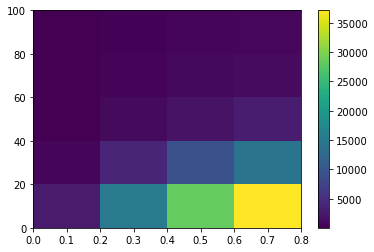

In [4]:
N_richness = 5 # number of richness bins
N_z = 4 # number of redshift bins

data_lz, z_edges, richness_edges, im  = plt.hist2d(dm_halos['redshift'], dm_halos['richness'],
                                       bins=[N_z, N_richness], cmin=1, range=[[0,0.8],[0,100]]);

plt.colorbar()

## Covariance

Here we are using a jackknife resampling method to compute the count covariance from the data (adapted from C. Payerne's [code](https://github.com/LSSTDESC/CLCosmo_Sim/blob/issue/15/binned_cosmological_analysis/cluster_abundance/CL_COUNT_DATAOPS_cluster_abundance_covariance.py) in the CLCosmoSim repo). Eventually, this will be replaced by the theoretical covariance provided by `TJPCov`.

In [5]:
# Adapted from Constantin Payerne's code in the CLCOSMO_sim repo

import healpy
from itertools import combinations
def compute_jackknife_covariance(catalog = None, 
                                proxy_colname = 'richness', redshift_colname = 'redshift',
                                ra_colname = 'ra', dec_colname = 'dec',
                                proxy_edges = richness_edges, z_edges = z_edges,        
                                hp_power = 7, N_delete = 1):
        r"""
        Attributes:
        -----------
        proxy_colname: str
            name of the proxy column
        redshift_colname: str
            name of the redshift column
        ra_colname: str
            name of the ra column
        dec_colname: str
            name of the dec column
        proxy_edges: array
            edges of the mass proxy bins
        z_edges: array
            edges of the redshift bins
        hp_power: int
            defines the number of healpix pixels. Healpix Nside = 2**hp_power
        N_delete: int
            number of jackknife region to delete each repetition
        Returns:
        --------
        cov_N: array
            Jackknife covariance matrix
        """
        proxy, redshift = np.array(catalog[proxy_colname]), np.array(catalog[redshift_colname])
        ra, dec =  np.array(catalog[ra_colname]), np.array(catalog[dec_colname])

        index = np.arange(len(proxy))
        healpix = healpy.ang2pix(2**hp_power, ra, dec, nest=True, lonlat=True)
        healpix_list_unique = np.unique(healpix)
        print(f'Number of JK regions: {len(healpix_list_unique)}')
        healpix_combination_delete = list(combinations(healpix_list_unique, N_delete))
        data_jack = []
        
        for i, hp_list_delete in enumerate(healpix_combination_delete):
            if (i/2000.).is_integer():
                print(i) # to track progress
            mask_in_area = np.isin(healpix, hp_list_delete)
            mask_out_area = np.invert(mask_in_area)
            data,_,_ = np.histogram2d(redshift[mask_out_area],proxy[mask_out_area],
                                            bins=[z_edges, proxy_edges])
            data_jack.append(data.flatten())
        
        data_jack = np.array(data_jack)
        N = np.stack((data_jack.astype(float)), axis = 1)
        n_jack = len(healpix_combination_delete)
        cov_N = (n_jack - 1) * np.cov(N, bias = False,ddof=0)
        coeff = (n_jack - N_delete) / (N_delete * n_jack)
        
        return cov_N * coeff

In [6]:
covariance = compute_jackknife_covariance(dm_halos)

Number of JK regions: 2154
0
2000


**Correlation matrix - the "large blocks" correspond to the $N_z$ redshift bins. In each redshift bin are the $N_{\rm richness}$ richness bins.**

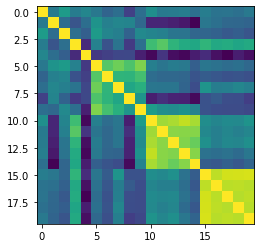

In [7]:
plt.imshow(np.corrcoef(covariance))
#plt.imshow((covariance))

## Store everything in a SACC file

In [8]:
s_count = sacc.Sacc()

In [9]:
# First we build the cluster count tracer
# Here we will store the richness and redshift bin information in metadata,

for i in np.arange(N_z):
    for j in np.arange(N_richness):
        name = f'clusters_{i}_{j}'
        metadata = {'Mproxy_name': 'richness',
                    'Mproxy_min': richness_edges[j], 'Mproxy_max': richness_edges[j+1],
                    'z_name': 'redshift',
                    'z_min': z_edges[i], 'z_max': z_edges[i+1],
                    'sky_area': metadata['sky_area']
                    
        }
        s_count.add_tracer('misc', name, metadata=metadata)
        

### First the count values

In [10]:
# One of our identifiers is a standard type name that is predefined
cluster_count = sacc.standard_types.cluster_mass_count_wl

for i in range(N_z): 
    for j in range(N_richness): 
        # Cluster number counts data
        tracer = f'clusters_{i}_{j}'
        value = data_lz[i][j]
        s_count.add_data_point(cluster_count, (tracer,), int(value), err=1.)

In [11]:
for d in s_count.data:
    print(d)

DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_0_0',), value=2777, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_0_1',), value=614, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_0_2',), value=143, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_0_3',), value=72, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_0_4',), value=35, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_1_0',), value=15167, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_1_1',), value=3925, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_1_2',), value=975, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_1_3',), value=426, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_1_4',), value=273, err=1.0)
DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_2_0',), value=

In [12]:
print(s_count.tracers['clusters_0_0'].metadata)
print(s_count.tracers['clusters_1_0'].metadata)
print(s_count.tracers['clusters_1_2'].metadata)

{'Mproxy_name': 'richness', 'Mproxy_min': 0.0, 'Mproxy_max': 20.0, 'z_name': 'redshift', 'z_min': 0.0, 'z_max': 0.2, 'sky_area': 439.78986}
{'Mproxy_name': 'richness', 'Mproxy_min': 0.0, 'Mproxy_max': 20.0, 'z_name': 'redshift', 'z_min': 0.2, 'z_max': 0.4, 'sky_area': 439.78986}
{'Mproxy_name': 'richness', 'Mproxy_min': 40.0, 'Mproxy_max': 60.0, 'z_name': 'redshift', 'z_min': 0.2, 'z_max': 0.4, 'sky_area': 439.78986}


### Then the add the covariance and save the file

In [13]:
s_count.add_covariance(covariance)

In [14]:
s_count.to_canonical_order()
s_count.save_fits("clusters.sacc", overwrite=True)

## Read in the SACC file and check content

In [15]:
s2 = sacc.Sacc.load_fits("./clusters.sacc")

In [16]:
s2.data

[DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_0_0',), value=2777, err=1.0),
 DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_0_1',), value=614, err=1.0),
 DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_0_2',), value=143, err=1.0),
 DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_0_3',), value=72, err=1.0),
 DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_0_4',), value=35, err=1.0),
 DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_1_0',), value=15167, err=1.0),
 DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_1_1',), value=3925, err=1.0),
 DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_1_2',), value=975, err=1.0),
 DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_1_3',), value=426, err=1.0),
 DataPoint(data_type='cluster_mass_count_wl', tracers=('clusters_1_4',), value=273, err=1.0),
 DataPoint(data_type='cluster_mass_count_wl', tracers=('cl

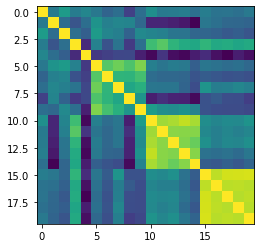

In [17]:
plt.imshow(np.corrcoef(s2.covariance.covmat))